# 01_raw_eda.ipynb
Purpose: Explore the raw e-shop clickstream file to understand session behavior, click sequences, page transitions, and to derive an initial conversion heuristic.
References:
- Project PDF: Clickstream Customer Conversion Analysis. :contentReference[oaicite:6]{index=6}
- EDA Guide (questions to guide exploration). :contentReference[oaicite:7]{index=7}


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')

### Load processed file

In [2]:
raw_path = Path("../data/processed/e-shop_clothing_2008_cleaned.csv") 
raw = pd.read_csv(raw_path, sep=',', engine='python')
raw.columns = [c.strip().lower().replace(' ','_').replace('(','').replace(')','').replace('-','_') for c in raw.columns]
raw.head(10)

,year,month,day,order,country,session_id,page_1_main_category,page_2_clothing_model,colour,location,model_photography,price,price_2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1
5,2008,4,1,6,29,1,3,C56,6,1,2,57,1,4
6,2008,4,1,7,29,1,3,C57,5,1,2,33,2,4
7,2008,4,1,8,29,1,4,P67,9,5,1,38,1,4
8,2008,4,1,9,29,1,4,P82,6,4,2,48,1,5
9,2008,4,1,1,29,2,2,B31,9,5,1,57,1,2


### Basic checks

In [3]:
print("shape:", raw.shape)
raw.info()
raw.isnull().sum()

shape: (165474, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   year                   165474 non-null  int64 
 1   month                  165474 non-null  int64 
 2   day                    165474 non-null  int64 
 3   order                  165474 non-null  int64 
 4   country                165474 non-null  int64 
 5   session_id             165474 non-null  int64 
 6   page_1_main_category   165474 non-null  int64 
 7   page_2_clothing_model  165474 non-null  object
 8   colour                 165474 non-null  int64 
 9   location               165474 non-null  int64 
 10  model_photography      165474 non-null  int64 
 11  price                  165474 non-null  int64 
 12  price_2                165474 non-null  int64 
 13  page                   165474 non-null  int64 
dtypes: int64(13), object(1)
memory u

year                     0
month                    0
day                      0
order                    0
country                  0
session_id               0
page_1_main_category     0
page_2_clothing_model    0
colour                   0
location                 0
model_photography        0
price                    0
price_2                  0
page                     0
dtype: int64

### Value counts for major categorical columns

In [4]:
for c in ['country','page1_main_category','colour','location','model_photography','price_2','page']:
    if c in raw.columns:
        print(f"\n--- {c} value counts ---")
        display(raw[c].value_counts().head(20))


--- country value counts ---


country
29    133963
9      18003
24      4091
46      2522
44      1385
16       834
21       811
34       716
41       684
3        256
27       227
12       210
42       170
37       163
10       152
22       144
31       144
28       139
38       137
15       125
Name: count, dtype: int64


--- colour value counts ---


colour
2     29764
3     29259
6     17476
4     16517
14    15939
9     13531
12     8830
1      7785
7      6876
13     6295
11     5292
10     3579
8      2664
5      1667
Name: count, dtype: int64


--- location value counts ---


location
1    34532
2    33383
5    27783
4    27377
3    21656
6    20743
Name: count, dtype: int64


--- model_photography value counts ---


model_photography
1    122439
2     43035
Name: count, dtype: int64


--- price_2 value counts ---


price_2
1    84695
2    80779
Name: count, dtype: int64


--- page value counts ---


page
1    93452
2    41037
3    19301
4     8861
5     2823
Name: count, dtype: int64

### Convert numeric columns and tidy session_id

In [5]:
num_cols = ['year','month','day','order','price','price_2','page']
for c in num_cols:
    if c in raw.columns:
        raw[c] = pd.to_numeric(raw[c], errors='coerce')
# ensure session_id tidy
raw['session_id'] = raw['session_id'].astype(str).str.strip()
raw['session_id'] = raw['session_id'].apply(lambda x: int(x) if x.isnumeric() else x)
raw.head()

,year,month,day,order,country,session_id,page_1_main_category,page_2_clothing_model,colour,location,model_photography,price,price_2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


### Session-level aggregates

In [6]:
agg = (
    raw.sort_values(['session_id','order'])
    .groupby('session_id', as_index=False)
    .agg(
        session_length=('order','count'),
        first_order=('order','min'),
        last_order=('order','max'),
        first_page=('page','first'),
        last_page=('page','last'),
        last_price=('price','last'),
        last_price_2=('price_2','last')
    )
)
agg.describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,24026.0,12013.500000,6935.853120,1.0,6007.25,12013.5,18019.75,24026.0
session_length,24026.0,6.887289,8.995161,1.0,2.00,4.0,8.00,195.0
first_order,24026.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
last_order,24026.0,6.887289,8.995161,1.0,2.00,4.0,8.00,195.0
first_page,24026.0,1.320653,0.688532,1.0,1.00,1.0,1.00,5.0
last_page,24026.0,1.784816,1.085971,1.0,1.00,1.0,2.00,5.0
last_price,24026.0,43.972696,12.322017,18.0,33.00,43.0,52.00,82.0
last_price_2,24026.0,1.472571,0.499257,1.0,1.00,1.0,2.00,2.0


### Plot session length distribution

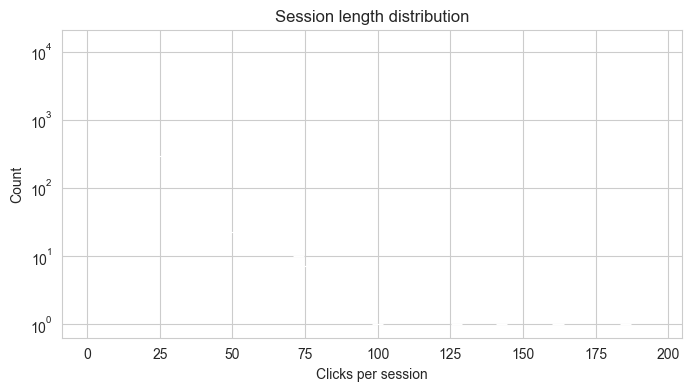

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(agg['session_length'], bins=50, log_scale=(False, True))
plt.title("Session length distribution")
plt.xlabel("Clicks per session")
plt.show()

### Inspect long sessions (outliers)

In [8]:
long_sessions = agg[agg['session_length'] > 50].sort_values('session_length', ascending=False)
display(long_sessions.head(20))

,session_id,session_length,first_order,last_order,first_page,last_page,last_price,last_price_2
22432,22433,195,1,195,1,4,52,1
13845,13846,192,1,192,1,4,52,1
22901,22902,185,1,185,1,3,28,2
8200,8201,161,1,161,1,2,48,2
19622,19623,142,1,142,1,4,52,1
14190,14191,128,1,128,1,3,28,2
8789,8790,121,1,121,1,3,33,2
19463,19464,120,1,120,1,3,28,2
6591,6592,112,1,112,1,4,33,2
20659,20660,112,1,112,1,2,33,2


### Explore how last_page relates to last_price_2

last_price_2,1,2
last_page,,
1,0.539762,0.460238
2,0.567528,0.432472
3,0.298739,0.701261
4,0.589297,0.410703
5,0.726552,0.273448


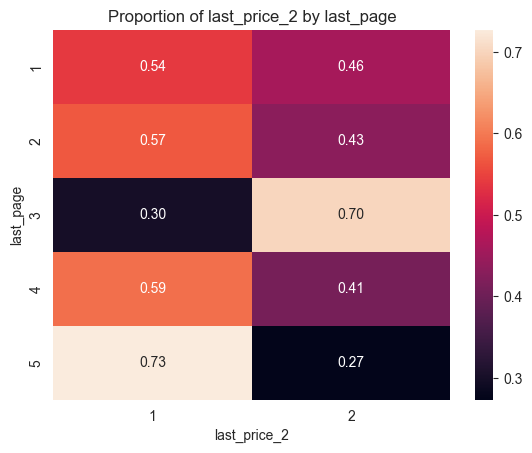

In [9]:
ct = pd.crosstab(agg['last_page'], agg['last_price_2'], normalize='index')
display(ct)
sns.heatmap(ct, annot=True, fmt=".2f")
plt.title("Proportion of last_price_2 by last_page")
plt.show()

### Heuristic conversion experiment

In [10]:
agg['converted_heuristic'] = ((agg['last_price_2'] == 1) | (agg['last_page'] >= 4)).astype(int)
agg['converted_heuristic'].value_counts(normalize=True)

converted_heuristic
1    0.563515
0    0.436485
Name: proportion, dtype: float64

### Sample sessions labeled converted to inspect click paths

In [11]:
example_sessions = agg[agg['converted_heuristic'] == 1].sample(5, random_state=42)['session_id'].tolist()
for sid in example_sessions:
    print(f"\nSession {sid}")
    display(raw[raw['session_id']==sid].sort_values('order')[['order','page_1_main_category','page_2_clothing_model','price','price_2','page']])


Session 5395


,order,page_1_main_category,page_2_clothing_model,price,price_2,page
37861,1,1,A38,62,1,3



Session 17775


,order,page_1_main_category,page_2_clothing_model,price,price_2,page
120989,1,4,P1,38,1,1
120990,2,4,P33,43,1,2
120991,3,4,P59,38,1,4
120992,4,4,P77,43,1,5



Session 15545


,order,page_1_main_category,page_2_clothing_model,price,price_2,page
106049,1,2,B24,57,1,2
106050,2,2,B25,38,2,2
106051,3,2,B26,57,1,2
106052,4,2,B23,38,2,2
106053,5,2,B19,38,2,2
106054,6,2,B31,57,1,2
106055,7,2,B11,43,2,1
106056,8,2,B10,67,1,1
106057,9,2,B12,38,2,1
106058,10,2,B14,62,1,1



Session 23461


,order,page_1_main_category,page_2_clothing_model,price,price_2,page
161376,1,1,A31,62,1,2
161377,2,1,A39,38,2,3
161378,3,1,A38,62,1,3
161379,4,2,B8,52,1,1
161380,5,2,B4,52,1,1
161381,6,4,P20,23,2,2
161382,7,4,P78,48,1,5
161383,8,4,P82,48,1,5



Session 1560


,order,page_1_main_category,page_2_clothing_model,price,price_2,page
10752,1,4,P6,43,1,1
10753,2,4,P15,38,1,1
10754,3,3,C8,48,1,1
10755,4,3,C1,28,2,1
10756,5,3,C16,28,2,1
10757,6,3,C33,48,1,2
10758,7,3,C42,28,2,3
10759,8,3,C41,28,2,3
10760,9,2,B24,57,1,2
10761,10,1,A9,82,1,1


### Country analysis: top countries by sessions

In [12]:
sessions_by_country = raw.groupby('session_id').first().reset_index().groupby('country').size().sort_values(ascending=False)
display(sessions_by_country.head(20))

country
29    19582
9      2261
46      681
24      527
44      240
41      127
21      102
16      101
34       88
12       28
27       26
42       26
38       25
10       23
28       21
3        20
15       18
22       16
37       15
2        11
dtype: int64

### Save session aggregates (for mapping to train/test later)

In [13]:
out_path = Path("../data/processed/session_aggregates_summary.csv")
agg.to_csv(out_path, index=False)
print("Saved session aggregates to:", out_path)

Saved session aggregates to: ..\data\processed\session_aggregates_summary.csv


### Time-based analysis: Month-wise session volume

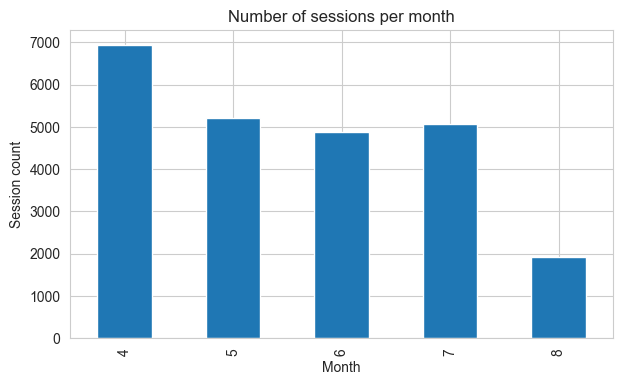

In [14]:
session_time = (
    raw.groupby('session_id')
       .first()
       .reset_index()[['session_id','month']]
)

month_counts = session_time['month'].value_counts().sort_index()

plt.figure(figsize=(7,4))
month_counts.plot(kind='bar')
plt.title("Number of sessions per month")
plt.xlabel("Month")
plt.ylabel("Session count")
plt.show()

Sessions are unevenly distributed across months, indicating seasonality in browsing behavior.

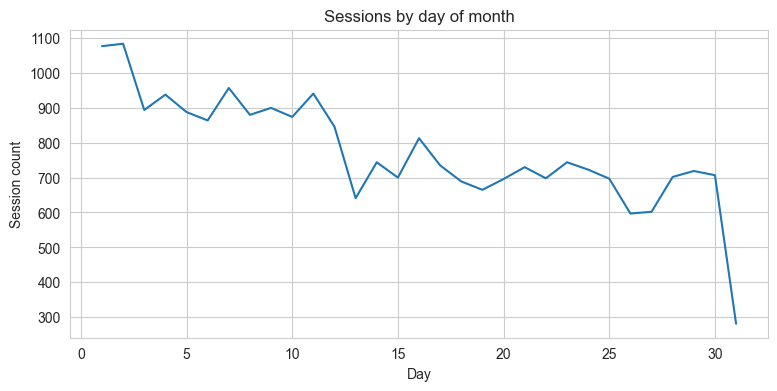

In [15]:
# ---- Time-based analysis: Day of month ----
day_counts = (
    raw.groupby('session_id')
       .first()
       .reset_index()['day']
       .value_counts()
       .sort_index()
)

plt.figure(figsize=(9,4))
day_counts.plot()
plt.title("Sessions by day of month")
plt.xlabel("Day")
plt.ylabel("Session count")
plt.show()


No strong monotonic trend is observed across days, suggesting browsing is spread throughout the month.

The dataset does not contain timestamps (hour/minute).  
Therefore, fine-grained time features such as session duration or hourly behavior could not be computed.  
This limitation is acknowledged and compensated by session-order-based features.

### Numeric correlation heatmap

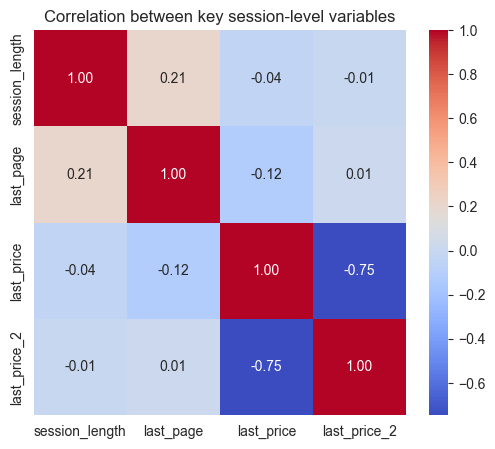

In [16]:
# ---- Correlation analysis (numeric session features) ----
session_numeric = agg[
    ['session_length','last_page','last_price','last_price_2']
].copy()

corr = session_numeric.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between key session-level variables")
plt.show()


Session length and last page depth show moderate correlation with price-related features, indicating deeper navigation for high-value items.

### Conversion distribution

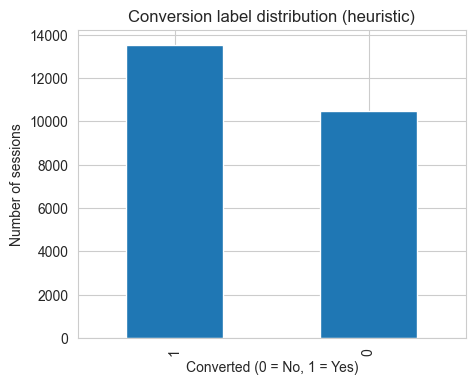

converted_heuristic
1    0.563515
0    0.436485
Name: count, dtype: float64

In [17]:
# ---- Target distribution: Conversion ----
conv_counts = agg['converted_heuristic'].value_counts()

plt.figure(figsize=(5,4))
conv_counts.plot(kind='bar')
plt.title("Conversion label distribution (heuristic)")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Number of sessions")
plt.show()

conv_counts / conv_counts.sum()

In [18]:
bounce_rate = (agg['session_length'] == 1).mean()
print(f"Approximate bounce rate: {bounce_rate:.2%}")

Approximate bounce rate: 20.99%


Single-click sessions are treated as bounce behavior, indicating low engagement.

### Exit page distribution

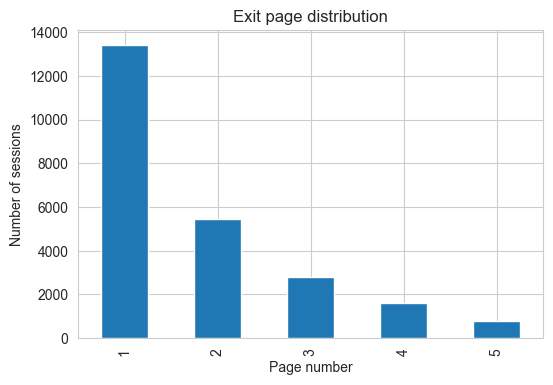

In [19]:
exit_pages = agg['last_page'].value_counts().sort_index()

plt.figure(figsize=(6,4))
exit_pages.plot(kind='bar')
plt.title("Exit page distribution")
plt.xlabel("Page number")
plt.ylabel("Number of sessions")
plt.show()

Most sessions exit at intermediate or deeper pages, suggesting exploratory behavior before abandonment or conversion.